In [62]:
# all tensorflow api is accessible through this
import tensorflow as tf        
# to visualize the resutls
import matplotlib.pyplot as plt 
# 70k mnist dataset that comes with the tensorflow container
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

In [63]:
tf.set_random_seed(0)

# load data
mnist = input_data.read_data_sets('input/fashion_data', 
                                  source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/',
                                  one_hot=True)

Extracting input/fashion_data/train-images-idx3-ubyte.gz
Extracting input/fashion_data/train-labels-idx1-ubyte.gz
Extracting input/fashion_data/t10k-images-idx3-ubyte.gz
Extracting input/fashion_data/t10k-labels-idx1-ubyte.gz


y = 3 (Dress)


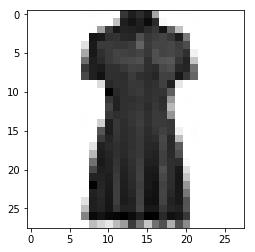

In [64]:
# From: https://medium.com/tensorist/classifying-fashion-articles-using-tensorflow-fashion-mnist-f22e8a04728a
# Our Fashion MNIST labels
# Create dictionary of target classes
label_dict = {
 0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'
}

# Take one sample

# Get 28x28 image
sample_1 = mnist.train.images[47].reshape(28,28)
# Get corresponding integer label from one-hot encoded data
sample_label_1 = np.where(mnist.train.labels[47] == 1)[0][0]
# Plot sample
print("y = {label_index} ({label})".format(label_index=sample_label_1, label=label_dict[sample_label_1]))
plt.imshow(sample_1, cmap='Greys')
plt.show()

In [65]:
# Regularization and Tuning
# - using "learning rate decay" and "dropout"
# 5-layers with a separate activations
# Neurons in each layer: 200, 100, 60, 30, 10

# 1. Define Variables and Placeholders
X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # The first dimension (None) will index the images
Y_ = tf.placeholder(tf.float32, [None, 10])       # Correct answers

#learning rate placeholder
#lr = tf.placeholder(tf.float32)
# placeholder for probability of keeping a node during dropout = 1.0 
# at test time (no dropout) and 0.75 at training time
pkeep = tf.placeholder(tf.float32)

# Weights initialized with small random values between -0.2 and +0.2
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1)) # 784 = 28 * 28
B1 = tf.Variable(tf.zeros([200]))
W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1))
B2 = tf.Variable(tf.zeros([100]))
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
B3 = tf.Variable(tf.zeros([60]))
W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
B4 = tf.Variable(tf.zeros([30]))
W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
B5 = tf.Variable(tf.zeros([10]))

In [66]:
# 2. Define the model
XX = tf.reshape(X, [-1, 784]) # flatten the images into a single line of pixels
useReLU = True

if useReLU:
    Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
    Y1d = tf.nn.dropout(Y1, pkeep)
    Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
    Y2d = tf.nn.dropout(Y2, pkeep)
    Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
    Y3d = tf.nn.dropout(Y3, pkeep)
    Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
    Y4d = tf.nn.dropout(Y4, pkeep)
    Ylogits = tf.nn.relu(tf.matmul(Y4d, W5) + B5)
else:
    Y1 = tf.nn.sigmoid(tf.matmul(XX, W1) + B1)
    Y1d = tf.nn.dropout(Y1, pkeep)
    Y2 = tf.nn.sigmoid(tf.matmul(Y1d, W2) + B2)
    Y2d = tf.nn.dropout(Y2, pkeep)
    Y3 = tf.nn.sigmoid(tf.matmul(Y2d, W3) + B3)
    Y3d = tf.nn.dropout(Y3, pkeep)
    Y4 = tf.nn.sigmoid(tf.matmul(Y3d, W4) + B4)
    Y4d = tf.nn.dropout(Y4, pkeep)
    Ylogits = tf.nn.sigmoid(tf.matmul(Y4d, W5) + B5)
    
Y = tf.nn.softmax(Ylogits)

In [67]:
# 3. Define the loss function  
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_) # calculate cross-entropy with logits
cross_entropy = tf.reduce_mean(cross_entropy)

In [68]:
# 4. Define the accuracy
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [69]:
# 5. Define an optimizer - Gradient Descent Optimizer or Adam Optimizer

# https://www.tensorflow.org/api_docs/python/tf/train/exponential_decay
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.005
# decay every 100000 steps with a base of 0.96
decay_steps = 100000
decay_rate = 0.96
# If the argument staircase is True, then global_step / decay_steps is an integer division and the decayed learning rate follows a staircase function.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate, staircase=True)

# Note: Passing global_step to minimize() will increment it at each step.
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)

In [70]:
# initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [71]:
# TODO : Set value for lr at session.run()
# TODO : Set value for pkeep at session.run() (depends on if it is training of testing)

# 3. In the training step - provide the appropriate pkeep
# 4. In the training step, if you used a placeholder - adjust learning rate - according to exponential decay rate
def training_step(i, update_test_data, update_train_data):

    print "\r", i,
    ####### actual learning 
    # reading batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)
    # the backpropagation training step
    sess.run(train_step, feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 0.75})
    
    ####### evaluating model performance for printing purposes
    # evaluation used to later visualize how well you did at a particular time in the training
    train_a = []
    train_c = []
    test_a = []
    test_c = []
    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: batch_X, Y_: batch_Y, pkeep: 1})
        train_a.append(a)
        train_c.append(c)

    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={XX: mnist.test.images, Y_: mnist.test.labels,  pkeep: 1})
        test_a.append(a)
        test_c.append(c)

    
    return (train_a, train_c, test_a, test_c)

In [72]:
# 6. Train and test the model, store the accuracy and loss per iteration

train_a = []
train_c = []
test_a = []
test_c = []
    
training_iter = 10000
epoch_size = 100
for i in range(training_iter):
    test = False
    if i % epoch_size == 0:
        test = True
    a, c, ta, tc = training_step(i, test, test)
    train_a += a
    train_c += c
    test_a += ta
    test_c += tc

9999                                                                                                                                                                                                                                 


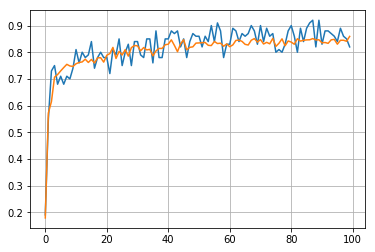

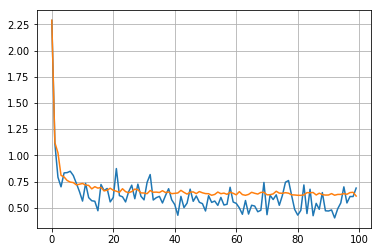

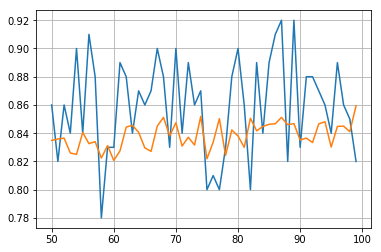

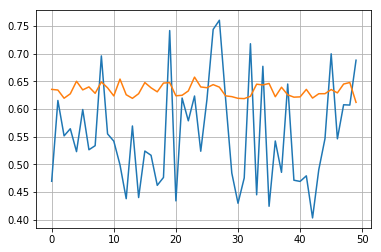

In [73]:
# 7. Plot and visualise the accuracy and loss

# accuracy training vs testing dataset
plt.plot(train_a)
plt.plot(test_a)
plt.grid(True)
plt.show()

# loss training vs testing dataset
plt.plot(train_c)
plt.plot(test_c)
plt.grid(True)
plt.show()

# Zoom in on the tail of the plots
zoom_point = 50
x_range = range(zoom_point,training_iter/epoch_size)
plt.plot(x_range, train_a[zoom_point:])
plt.plot(x_range, test_a[zoom_point:])
plt.grid(True)
plt.show()

plt.plot(train_c[zoom_point:])
plt.plot(test_c[zoom_point:])
plt.grid(True)
plt.show()

In [74]:
# Accuracy
print(sess.run(accuracy, feed_dict={XX: mnist.test.images, Y_: mnist.test.labels, pkeep: 1}))

0.8424
